# Challenge: Model Comparison
Here let's work on regression. Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. Submit a link to your notebook below.

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model
from sklearn import neighbors
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

%matplotlib inline

## Load Data

In [2]:
water_df = pd.read_csv('bottle.csv')

/Users/Lisa/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
water_df.columns

Index(['Cst_Cnt', 'Btl_Cnt', 'Sta_ID', 'Depth_ID', 'Depthm', 'T_degC',
       'Salnty', 'O2ml_L', 'STheta', 'O2Sat', 'Oxy_µmol/Kg', 'BtlNum',
       'RecInd', 'T_prec', 'T_qual', 'S_prec', 'S_qual', 'P_qual', 'O_qual',
       'SThtaq', 'O2Satq', 'ChlorA', 'Chlqua', 'Phaeop', 'Phaqua', 'PO4uM',
       'PO4q', 'SiO3uM', 'SiO3qu', 'NO2uM', 'NO2q', 'NO3uM', 'NO3q', 'NH3uM',
       'NH3q', 'C14As1', 'C14A1p', 'C14A1q', 'C14As2', 'C14A2p', 'C14A2q',
       'DarkAs', 'DarkAp', 'DarkAq', 'MeanAs', 'MeanAp', 'MeanAq', 'IncTim',
       'LightP', 'R_Depth', 'R_TEMP', 'R_POTEMP', 'R_SALINITY', 'R_SIGMA',
       'R_SVA', 'R_DYNHT', 'R_O2', 'R_O2Sat', 'R_SIO3', 'R_PO4', 'R_NO3',
       'R_NO2', 'R_NH4', 'R_CHLA', 'R_PHAEO', 'R_PRES', 'R_SAMP', 'DIC1',
       'DIC2', 'TA1', 'TA2', 'pH2', 'pH1', 'DIC Quality Comment'],
      dtype='object')

In [4]:
# Get rid of unwanted columns
water_df = water_df[['Depthm', 'T_degC', 'Salnty']]

# Rename columns
water_df.rename(columns = {'Depthm':'depth', 'T_degC':'temp', 'Salnty':'salnty'}, inplace=True)

# Take random sample of initial dataset
water_df = water_df.sample(n=1000, random_state=1)

water_df

,depth,temp,salnty
162807,35,13.33,33.410
22398,73,16.94,33.870
136704,74,10.92,33.360
61221,75,10.31,33.350
687320,100,11.78,33.312
...,...,...,...
274306,300,7.36,34.197
36129,600,6.07,34.400
517535,148,10.30,33.334
673859,72,15.90,33.343


### Data Info
Obtained from https://www.kaggle.com/sohier/calcofi#bottle.csv

* depth = water depth in meters
* temp = water temp in degree celsius
* salnty = water salinity in g of salt per kg of water (g/kg)

### Objective
Build a KNN Regression model and an OLS regression model to predict water temperature using water depth and salinity.

## Explore and Clean Data

In [5]:
water_df.describe()

,depth,temp,salnty
count,1000.00000,993.000000,959.000000
mean,245.47100,10.651397,33.856864
std,328.74541,4.314818,0.460375
min,0.00000,1.740000,32.456000
25%,44.75000,7.410000,33.498000
50%,125.00000,9.980000,33.874000
75%,300.00000,13.840000,34.212000
max,2771.00000,28.340000,35.862000


In [6]:
# Check for missing values (na)
water_df.isnull().sum()

depth      0
temp       7
salnty    41
dtype: int64

In [7]:
# Drop records with missing values
water_df = water_df.dropna()
water_df

,depth,temp,salnty
162807,35,13.33,33.410
22398,73,16.94,33.870
136704,74,10.92,33.360
61221,75,10.31,33.350
687320,100,11.78,33.312
...,...,...,...
274306,300,7.36,34.197
36129,600,6.07,34.400
517535,148,10.30,33.334
673859,72,15.90,33.343


In [8]:
# Transform water depth to make distribution more normal
# Use log10(x + 1) due to zero values
water_df['log_depth'] = np.log10(water_df['depth'] + 1)
water_df

/Users/Lisa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,depth,temp,salnty,log_depth
162807,35,13.33,33.410,1.556303
22398,73,16.94,33.870,1.869232
136704,74,10.92,33.360,1.875061
61221,75,10.31,33.350,1.880814
687320,100,11.78,33.312,2.004321
...,...,...,...,...
274306,300,7.36,34.197,2.478566
36129,600,6.07,34.400,2.778874
517535,148,10.30,33.334,2.173186
673859,72,15.90,33.343,1.863323


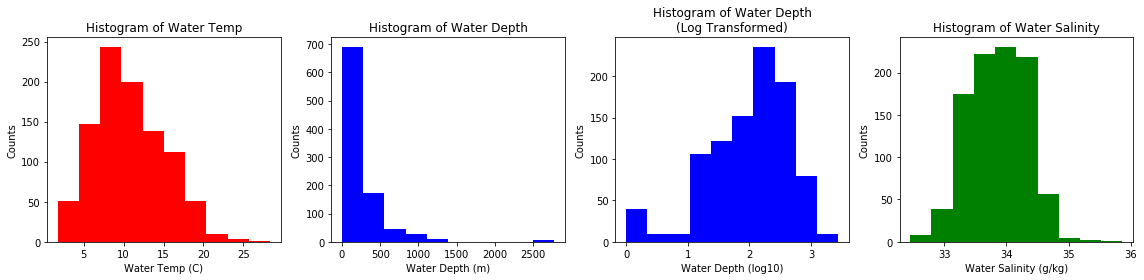

In [9]:
# Look at distribution of target and explanatory variables
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.hist(water_df['temp'], color='r')
plt.xlabel('Water Temp (C)')
plt.ylabel('Counts')
plt.title('Histogram of Water Temp')

plt.subplot(1, 4, 2)
plt.hist(water_df['depth'], color='b')
plt.xlabel('Water Depth (m)')
plt.ylabel('Counts')
plt.title('Histogram of Water Depth')

plt.subplot(1, 4, 3)
plt.hist(water_df['log_depth'], color='b')
plt.xlabel('Water Depth (log10)')
plt.ylabel('Counts')
plt.title('Histogram of Water Depth\n(Log Transformed)')

plt.subplot(1, 4, 4)
plt.hist(water_df['salnty'], color='g')
plt.xlabel('Water Salinity (g/kg)')
plt.ylabel('Counts')
plt.title('Histogram of Water Salinity')

plt.tight_layout()
plt.show()

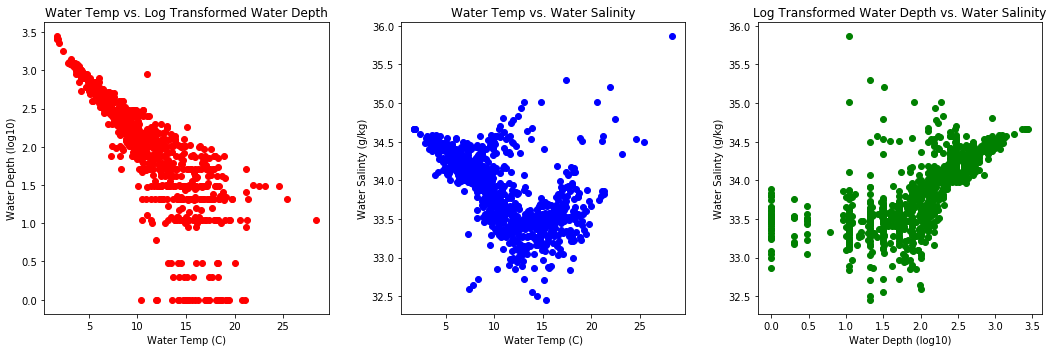

In [10]:
# Look at relationship between water temp, water depth, and water salinity
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(water_df['temp'],
            water_df['log_depth'],
            color='r')
plt.xlabel('Water Temp (C)')
plt.ylabel('Water Depth (log10)')
plt.title('Water Temp vs. Log Transformed Water Depth')

plt.subplot(1, 3, 2)
plt.scatter(water_df['temp'],
            water_df['salnty'],
            color='b')
plt.xlabel('Water Temp (C)')
plt.ylabel('Water Salinty (g/kg)')
plt.title('Water Temp vs. Water Salinity')

plt.subplot(1, 3, 3)
plt.scatter(water_df['log_depth'],
            water_df['salnty'],
            color='g')
plt.xlabel('Water Depth (log10)')
plt.ylabel('Water Salinty (g/kg)')
plt.title('Log Transformed Water Depth vs. Water Salinity')

plt.tight_layout()
plt.show()

In [11]:
# Look at correlation matrix
water_df.corr()

,depth,temp,salnty,log_depth
depth,1.000000,-0.707034,0.610412,0.694643
temp,-0.707034,1.000000,-0.538027,-0.829710
salnty,0.610412,-0.538027,1.000000,0.662828
log_depth,0.694643,-0.829710,0.662828,1.000000


## Build KNN Regression Models

### Depth Only

In [12]:
# Find optimal k and weights
grid_params = {
    'n_neighbors': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95],
    'weights': ['uniform', 'distance']} 

# Use z-scores instead of raw data
X = pd.DataFrame(stats.zscore(water_df['log_depth']))
Y = water_df['temp']

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, grid_params, cv=5)
results = model.fit(X, Y)

print(results.best_params_)

{'n_neighbors': 45, 'weights': 'uniform'}


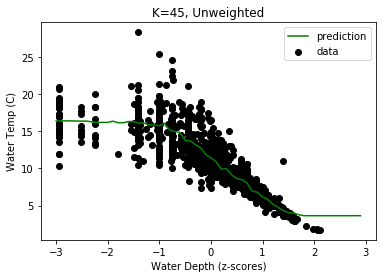

In [13]:
# Use optimal parameters to build KNN model
knn = neighbors.KNeighborsRegressor(n_neighbors=45, weights='uniform')

knn.fit(X, Y)

# Set up our prediction line
T = np.arange(-3, 3, 0.1)[:, np.newaxis]

# Trailing underscores are common convention for a prediction
Y_ = knn.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.xlabel('Water Depth (z-scores)')
plt.ylabel('Water Temp (C)')
plt.title('K=45, Unweighted')

plt.show()

In [14]:
# Test accuracy of model
score = cross_val_score(knn, X, Y, cv=5)
print(score)
print('Unweighted Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.75843457 0.78625529 0.72458534 0.82066505 0.81802064]
Unweighted Accuracy: 0.78 (+/- 0.07)


### Salinity Only

In [15]:
# Find optimal k and weights
grid_params = {
    'n_neighbors': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95],
    'weights': ['uniform', 'distance']} 

# Use z-scores instead of raw data
X = pd.DataFrame(stats.zscore(water_df['salnty']))
Y = water_df['temp']

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, grid_params, cv=5)
results = model.fit(X, Y)

print(results.best_params_)

{'n_neighbors': 55, 'weights': 'uniform'}


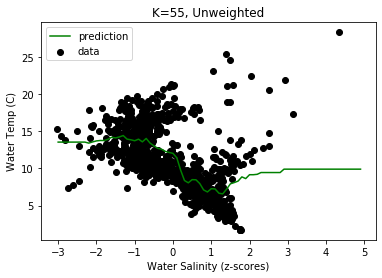

In [16]:
# Use optimal parameters to build KNN model
knn = neighbors.KNeighborsRegressor(n_neighbors=55, weights='uniform')

knn.fit(X, Y)

# Set up our prediction line
T = np.arange(-3, 5, 0.1)[:, np.newaxis]

# Trailing underscores are common convention for a prediction
Y_ = knn.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.xlabel('Water Salinity (z-scores)')
plt.ylabel('Water Temp (C)')
plt.title('K=55, Unweighted')

plt.show()

In [17]:
# Test accuracy of model
score = cross_val_score(knn, X, Y, cv=5)
print(score)
print('Unweighted Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.40966548 0.50150048 0.24056744 0.43700384 0.51874497]
Unweighted Accuracy: 0.42 (+/- 0.20)


### Depth and Salinity

In [18]:
# Find optimal k and weights
grid_params = {
    'n_neighbors': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95],
    'weights': ['uniform', 'distance']} 

# Use z-scores instead of raw data
X = pd.DataFrame(stats.zscore(water_df['log_depth']),
                 stats.zscore(water_df['salnty']))
Y = water_df['temp']

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, grid_params, cv=5)
results = model.fit(X, Y)

print(results.best_params_)

{'n_neighbors': 45, 'weights': 'uniform'}


In [19]:
# Use optimal parameters to build KNN model
knn = neighbors.KNeighborsRegressor(n_neighbors=45, weights='uniform')

knn.fit(X, Y)

# Test accuracy of model
score = cross_val_score(knn, X, Y, cv=5)
print(score)
print('Unweighted Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.75843457 0.78625529 0.72458534 0.82066505 0.81802064]
Unweighted Accuracy: 0.78 (+/- 0.07)


## Build OLS Regression Models

### Depth Only

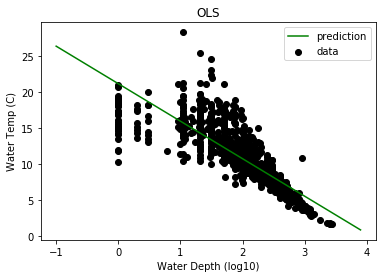

In [20]:
# Build OLS model
X = water_df[['log_depth']]
Y = water_df['temp']

lrm = linear_model.LinearRegression()

lrm.fit(X, Y)

# Set up our prediction line
T = np.arange(-1, 4, 0.1)[:, np.newaxis]

# Trailing underscores are common convention for a prediction
Y_ = lrm.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.xlabel('Water Depth (log10)')
plt.ylabel('Water Temp (C)')
plt.title('OLS')

plt.show()

In [21]:
# Test accuracy of model
score = cross_val_score(lrm, X, Y, cv=5)
print(score)
print('Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.68952972 0.67153306 0.60224084 0.74518308 0.70228318]
Accuracy: 0.68 (+/- 0.09)


### Salinity Only

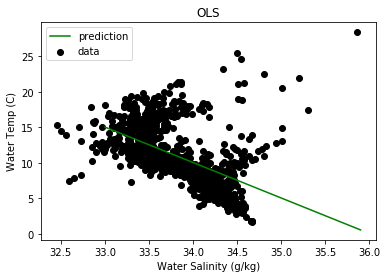

In [22]:
# Build OLS model
X = water_df[['salnty']]
Y = water_df['temp']

lrm = linear_model.LinearRegression()

lrm.fit(X, Y)

# Set up our prediction line
T = np.arange(33, 36, 0.1)[:, np.newaxis]

# Trailing underscores are common convention for a prediction
Y_ = lrm.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.xlabel('Water Salinity (g/kg)')
plt.ylabel('Water Temp (C)')
plt.title('OLS')

plt.show()

In [23]:
# Test accuracy of model
score = cross_val_score(lrm, X, Y, cv=5)
print(score)
print('Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.23007655 0.27228745 0.14878928 0.36070382 0.38845358]
Accuracy: 0.28 (+/- 0.17)


### Depth and Salinity

In [24]:
# Build OLS model
X = water_df[['log_depth', 'salnty']]
Y = water_df['temp']

lrm = linear_model.LinearRegression()

lrm.fit(X, Y)

# Test accuracy of model
score = cross_val_score(lrm, X, Y, cv=5)
print(score)
print('Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.68801427 0.67103352 0.6022627  0.74176125 0.69590202]
Accuracy: 0.68 (+/- 0.09)


### Depth, Salinity, and Interaction

In [25]:
# Build OLS model

water_df['dep_int_sal'] = water_df['log_depth'] * water_df['salnty']

X = water_df[['log_depth', 'salnty', 'dep_int_sal']]
Y = water_df['temp']

lrm = linear_model.LinearRegression()

lrm.fit(X, Y)

# Test accuracy of model
score = cross_val_score(lrm, X, Y, cv=5)
print(score)
print('Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.75857078 0.75717425 0.6938147  0.76794473 0.76384405]
Accuracy: 0.75 (+/- 0.05)


/Users/Lisa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Commentary

My best KNN model is only slightly better than my best OLS model as measured by accuracy plus/minus variance (0.78 +/- 0.07 vs. 0.75 +/- 0.05).

Interestingly, both models did just as well with depth alone as they did with depth and salinity, indicating that salinity alone does not add any unique information to either type of regression model. That being said, the interaction between depth and salinity did improve the accuracy of the OLS model quite a bit (0.68 +/- 0.09 vs. 0.75 +/- 0.05).

I was unable to include an interaction term in the KNN model, which may suggest a possible advantage of OLS models over KNN models. My gut reaction is to conclude that OLS models will perform better on data that can be explained by a linear/polynomial function, while KNN models will perform better on non-linear/non-polynomial data. Likewise, KNN models may be a safer option when the relationship is unknown.